# Clustering - Tuto 2

In [1]:
# Libraries import section
import os

import xarray as xr
import numpy as np
from scipy import stats

from sklearn import preprocessing
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

import matplotlib
# matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="deep", color_codes=True)

In [2]:
# Define usefull functions

def create_map(extent=[-180, 180, -70, 70]):
    """Create an empty map"""
    fig = plt.figure(figsize=(12,4),dpi=200)
    proj = ccrs.PlateCarree()
    ax = fig.add_axes([0,0,1,1],projection=proj)
    ax.set_extent(extent, crs=proj)
    gl=ax.gridlines(crs=proj, draw_labels=True,
        linewidth=0.5, color=[0.6]*3, alpha=0.5, linestyle='--')
    # gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/10+1))
    # gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/5+1))
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/30+1))
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/20+1))
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor=[0.7]*3)
    ax.add_feature(cfeature.COASTLINE)
    return fig, proj, ax

def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

# Load data

In [3]:
# https://storage.cloud.google.com/sonific01/ARGO/GLOB_HOMOGENEOUS_variables_3subset_3.nc?_ga=2.221604568.-1386953781.1538471925

# Define where to find the Argo file on disk:
ncroot = '/home1/datahome/gmaze/datawork/data/ARGO/copoda_db/global'
ncfile = 'GLOB_HOMOGENEOUS_variables_3subset_1.nc'
#ncfile = 'GLOB_HOMOGENEOUS_variables_3subset_*.nc'

# Load Argo SDL data:
ds = xr.open_mfdataset(os.path.join(ncroot,ncfile))
# ds = xr.open_dataset(os.path.join(ncroot,ncfile),chunks={'N_PROF':16000})
ds = ds.set_coords({'LATITUDE','LONGITUDE','TIME'})
print ds

<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 67010)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE   (N_PROF) float32 dask.array<shape=(67010,), chunksize=(67010,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(67010,), chunksize=(67010,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(67010,), chunksize=(67010,)>
Dimensions without coordinates: N_PROF
Data variables:
    DBINDEX    (N_PROF) float64 dask.array<shape=(67010,), chunksize=(67010,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(67010, 302)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(67010, 302)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(67010, 302)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(67010, 302)>
Attributes:
    Title:             VENTHSAL-IA
    long_title:        Argo subset of plain pr

# Define a 2D dataset

In [4]:
z = -250 # Depth level to select
T = ds.TEMP.sel(DEPTH=z, method='nearest')
S = ds.PSAL.sel(DEPTH=z, method='nearest')

# or:

T = ds.TEMP.sel(DEPTH=0, method='nearest')
S = ds.TEMP.sel(DEPTH=-1000, method='nearest')

# Sub-sample just for faster computation
ii = np.random.choice(range(T.shape[0]), 10000, replace=False)
T = T[ii]
S = S[ii]

Tlabel = "%s at %0.2fm depth"%(T.name,T['DEPTH'])
Slabel = "%s at %0.2fm depth"%(S.name,S['DEPTH'])

# Create a new DataSet to store all results:
# RES = xr.merge([T,S])
RES = xr.concat([T,S], dim='n_features')
print RES

# Creare a simple 2D numpy array for scikit-learn
X = np.append(T.values[np.newaxis].T, S.values[np.newaxis].T, axis=1)
print X.shape # shape [n_samples, n_features=2]

<xarray.DataArray 'TEMP' (n_features: 2, N_PROF: 10000)>
dask.array<shape=(2, 10000), dtype=float32, chunksize=(1, 10000)>
Coordinates:
    LATITUDE   (N_PROF) float32 -44.542 -32.189 -13.588 ... -59.702 -35.596
    LONGITUDE  (N_PROF) float32 -20.274 -94.272 118.614 ... 142.278 -104.255
    TIME       (N_PROF) datetime64[ns] 2009-11-24T22:25:46.875000064 ... 2010-07-28T04:42:39.375000064
    DEPTH      (n_features) float32 0.0 -1000.0
Dimensions without coordinates: n_features, N_PROF
Attributes:
    long_name:       Sea Temperature In-Situ ITS-90 Scale
    standard_name:   sea_water_temperature
    units:           degree_Celsius
    valid_min:       -2.5.f
    valid_max:       40.f
    C_format:        %9.3f
    FORTRAN_format:  F9.3
    resolution:      0.001f
(10000, 2)


# Dataset PDF

/home1/datahome/gmaze/conda-env/lopsformationdata/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


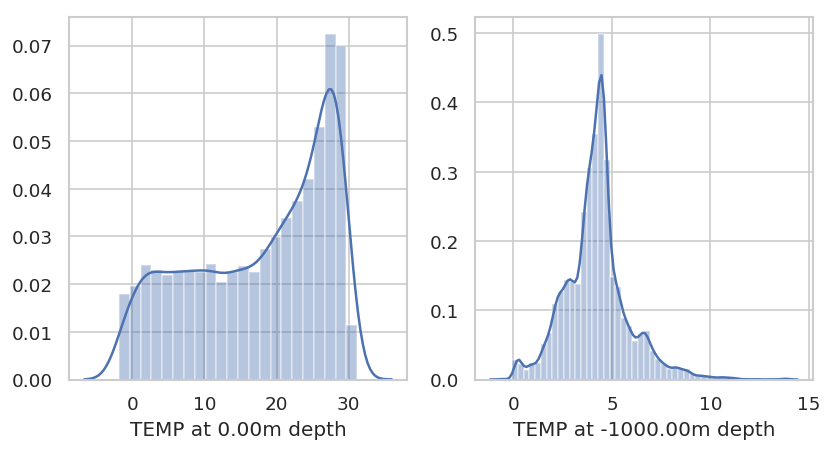

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.5), dpi=120, facecolor='w', edgecolor='k')
sns.distplot(T, norm_hist=True, axlabel=Tlabel, ax=ax[0])
sns.distplot(S, norm_hist=True, axlabel=Slabel, ax=ax[1])

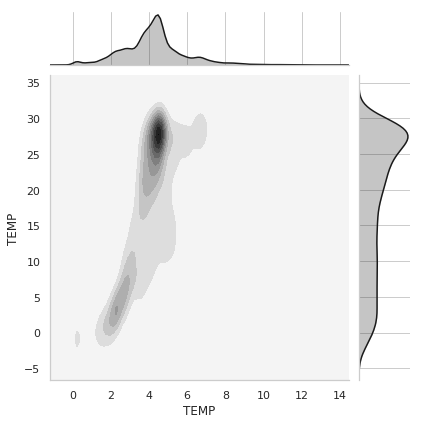

In [6]:
# sns.jointplot(x=S, y=T, kind="kde",\
#               xlim=vrange(S),ylim=vrange(T),\
#               height=7, ratio=4, space=0)\
#             .set_axis_labels("Salinity", "Temperature")
# plt.suptitle("%0.2fm vs %0.2fm depth"%(DPTmodel[iz1],DPTmodel[iz2]))
# plt.show()

g = (sns.jointplot(x=S, y=T, kind="kde", color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6))

# Clustering in 2D

Clearly from the figure above, one can see that the dataset exhibits several modes. 
In other words, data samples agregated into several clusters.

Let's identify them

In [7]:
from sklearn import metrics

In [8]:
# Scaler

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_
print "Data mean, std:", X_ave, X_std

# Normalize data:
Xn = scaler.transform(X) 

# Add results to the dataset:
RES['TEMPnorm'] = xr.DataArray(Xn[:,0], dims='N_PROF')
RES['PSALnorm'] = xr.DataArray(Xn[:,1], dims='N_PROF')

Data mean, std: [17.71176563  4.22884766] [9.51257376 1.61810476]


In [9]:
# Clustering with GMM


In [10]:
# Clustering with DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=50).fit(Xn)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xn, labels))

# Add results to the dataset:
RES['DBSCAN'] = xr.DataArray(labels, dims='N_PROF')

Estimated number of clusters: 6
Silhouette Coefficient: -0.427


Cluster:  0 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
Cluster:  1 (0.9139561707035756, 0.36239907727797, 0.27935409457900806, 1.0)
Cluster:  2 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
Cluster:  3 (0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)
Cluster:  4 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569, 1.0)
Cluster:  5 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965, 1.0)
Cluster:  -1 [0, 0, 0, 0.2]


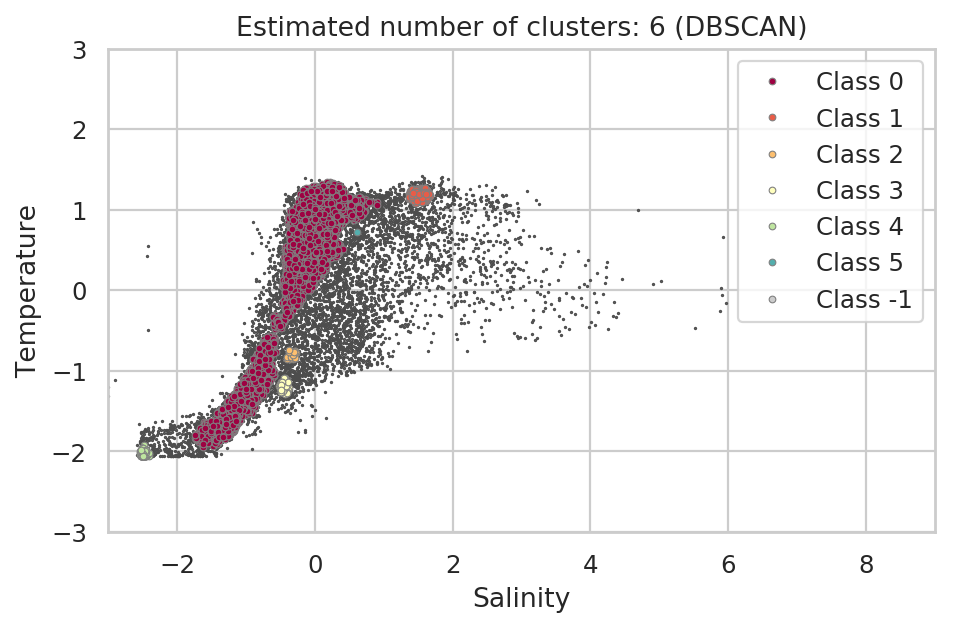

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.6), dpi=160, facecolor='w', edgecolor='k')

# 
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.plot(Xn[:,1],Xn[:,0],'k.',markersize=1,color=[0.3]*3)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
    print "Cluster: ", k, col
    
    class_member_mask = (labels == k)

    xy = Xn[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor=[0.5]*3, markersize=3, markeredgewidth=0.5, label="Class %i"%(k))

#     xy = Xn[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='none', markersize=3, label="Noise class %i"%(k))

plt.xlim(-3,9)
plt.ylim(-3,3)
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('Estimated number of clusters: %d (DBSCAN)' % n_clusters_)
plt.legend()
plt.show()

Cluster:  0 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
Cluster:  1 (0.9139561707035756, 0.36239907727797, 0.27935409457900806, 1.0)
Cluster:  2 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
Cluster:  3 (0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)
Cluster:  4 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569, 1.0)
Cluster:  5 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965, 1.0)
Cluster:  -1 [0, 0, 0, 0.2]


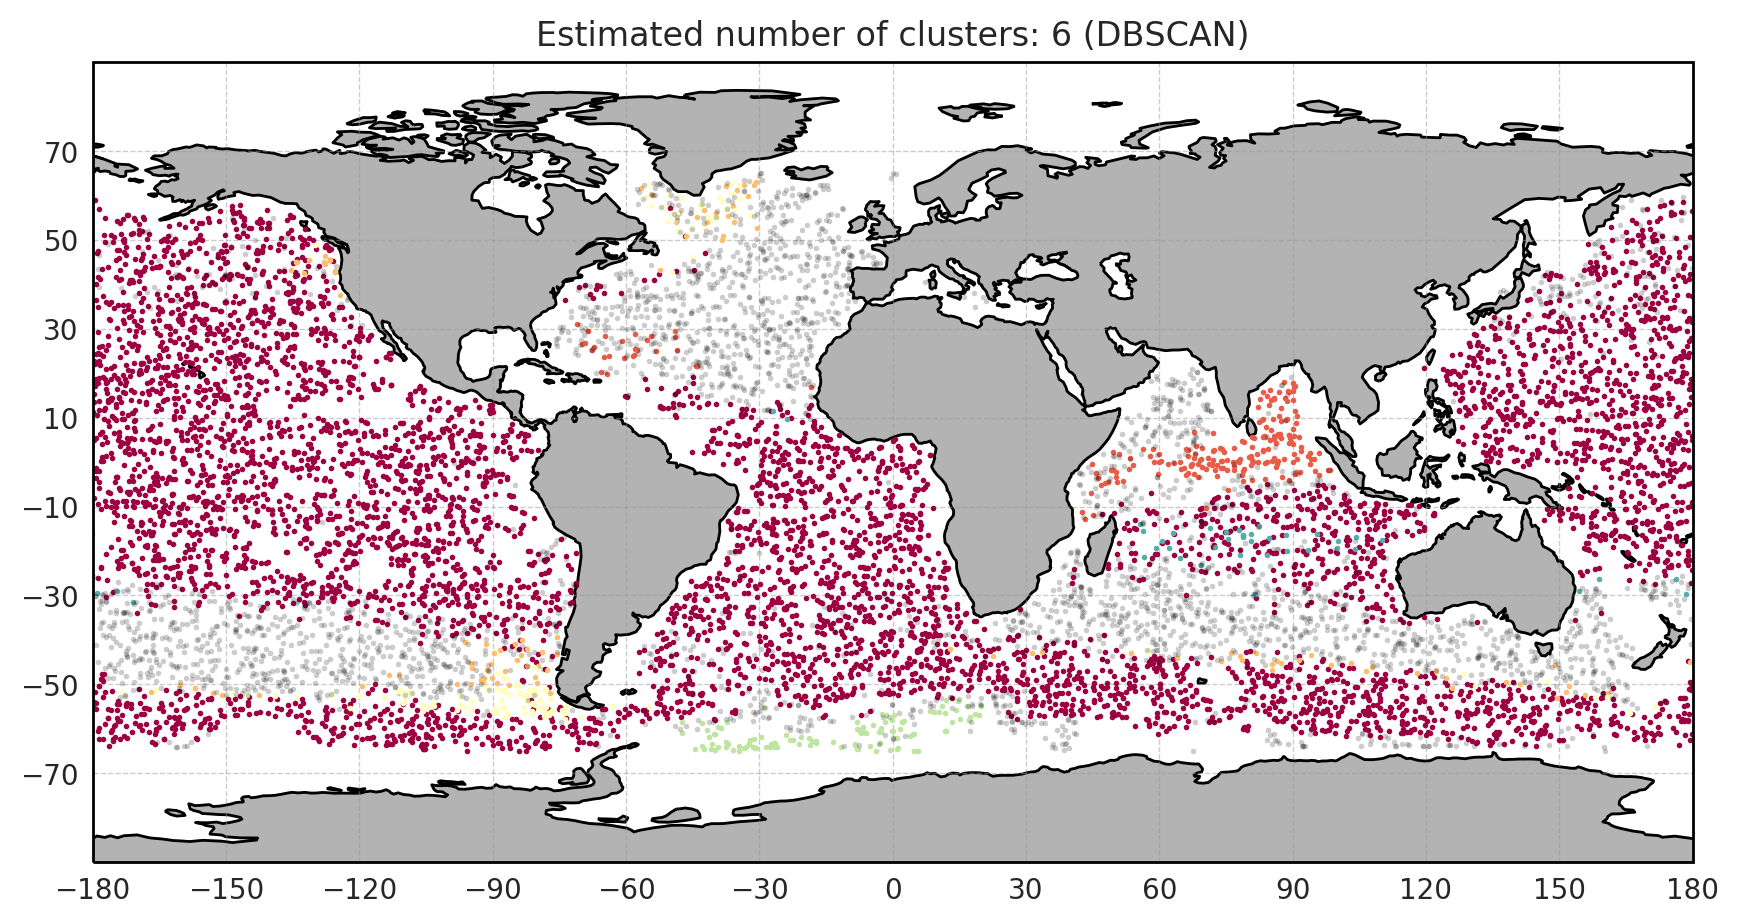

In [12]:
fig, proj, ax = create_map(extent=[-180, 180, -90, 90])

# plt.scatter(RES.LONGITUDE,RES.LATITUDE,5,RES.DBSCAN,transform=proj)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
    print "Cluster: ", k, col
    
    class_member_mask = (RES.DBSCAN == k)

    plt.plot(RES.LONGITUDE[class_member_mask],
                RES.LATITUDE[class_member_mask],
                 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=2,  
             label="Class %i"%(k), transform=proj)

plt.title('Estimated number of clusters: %d (DBSCAN)' % n_clusters_)
# plt.legend()
plt.show()

In [15]:
# Clustering with KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0).fit(Xn)
labels = kmeans.predict(Xn)
n_clusters_ = kmeans.n_clusters
kmeans.cluster_centers_.shape

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xn, labels))

# Add results to the dataset:
RES['KMEANS'] = xr.DataArray(labels, dims='N_PROF')

Silhouette Coefficient: 0.448


Cluster:  0 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
Cluster:  1 (0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0)
Cluster:  2 (0.996078431372549, 0.8784313725490196, 0.5450980392156862, 1.0)
Cluster:  3 (0.9019607843137256, 0.9607843137254902, 0.5960784313725491, 1.0)
Cluster:  4 (0.4, 0.7607843137254902, 0.6470588235294118, 1.0)
Cluster:  5 (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)


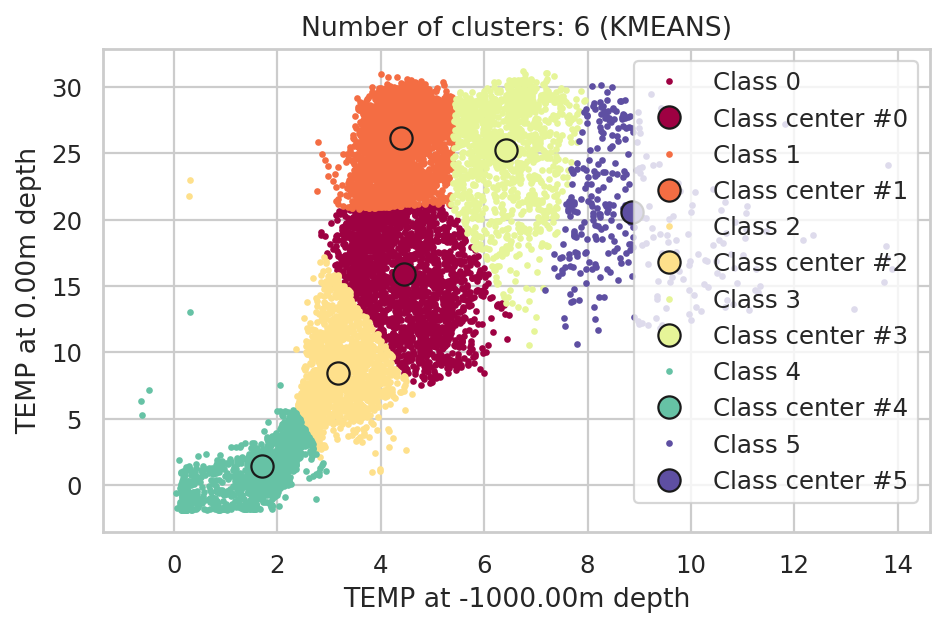

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.6), dpi=160, facecolor='w', edgecolor='k')

unique_labels = np.unique(RES['KMEANS'])
n_clusters_ = unique_labels.shape[0]
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(range(n_clusters_), colors):
    print "Cluster: ", k, col
    class_members = RES['KMEANS'] == k
#     plt.plot(RES['PSALnorm'][class_members], RES['TEMPnorm'][class_members], '.', 
#              markerfacecolor=tuple(col), markeredgecolor='none')

#     cluster_center = kmeans.cluster_centers_[k,:]
#     plt.plot(cluster_center[1], cluster_center[0], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14, label='Class %i'%(k))
    
    
    plt.plot(RES.sel(n_features=1)[class_members], RES.sel(n_features=0)[class_members], '.', 
             markerfacecolor=tuple(col), markeredgecolor='none', label='Class %i'%(k))

    cluster_center = scaler.inverse_transform(kmeans.cluster_centers_[k,:])
    plt.plot(cluster_center[1], cluster_center[0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label='Class center #%i'%(k))

# plt.xlim(-3,9)
# plt.ylim(-3,3)
plt.xlabel(Slabel)
plt.ylabel(Tlabel)
plt.title('Number of clusters: %i (KMEANS)' % n_clusters_)
plt.legend()
plt.show()

Cluster:  0 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
Cluster:  1 (0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0)
Cluster:  2 (0.996078431372549, 0.8784313725490196, 0.5450980392156862, 1.0)
Cluster:  3 (0.9019607843137256, 0.9607843137254902, 0.5960784313725491, 1.0)
Cluster:  4 (0.4, 0.7607843137254902, 0.6470588235294118, 1.0)
Cluster:  5 (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)


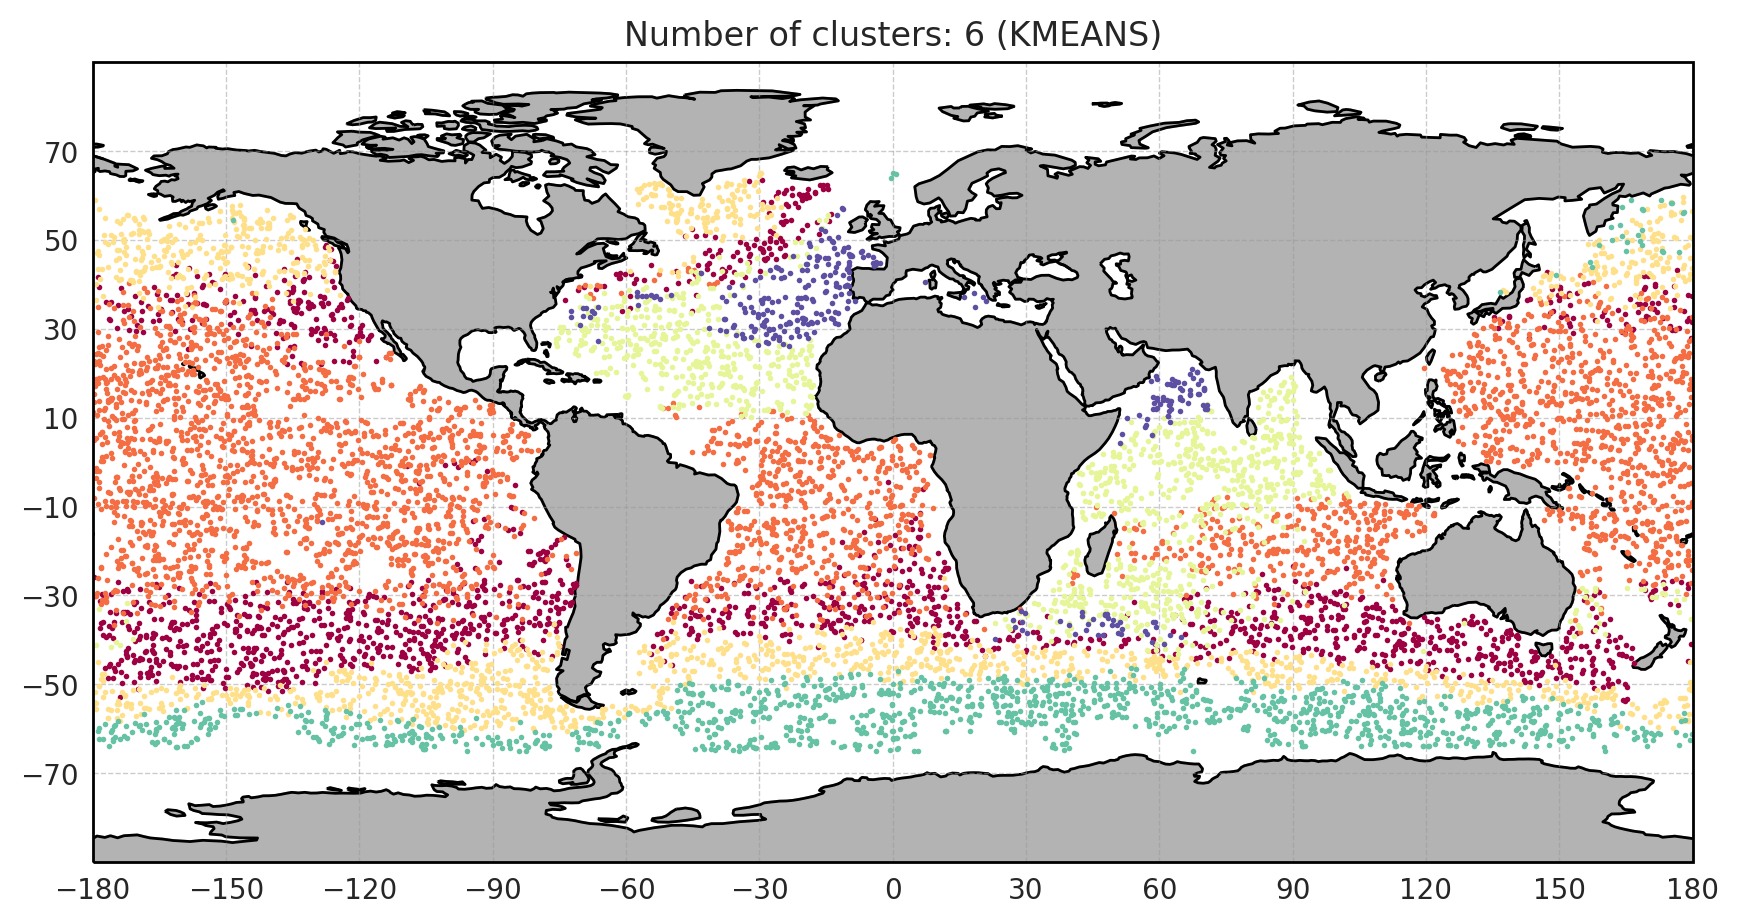

In [17]:
fig, proj, ax = create_map(extent=[-180, 180, -90, 90])

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
    print "Cluster: ", k, col
    
    class_member_mask = (RES.KMEANS == k)

    plt.plot(RES.LONGITUDE[class_member_mask],
                RES.LATITUDE[class_member_mask],
                 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=2,  
             label="Class %i"%(k), transform=proj)

plt.title('Number of clusters: %d (KMEANS)' % n_clusters_)
# plt.legend()
plt.show()

In [ ]:
RES

(10000, 4)


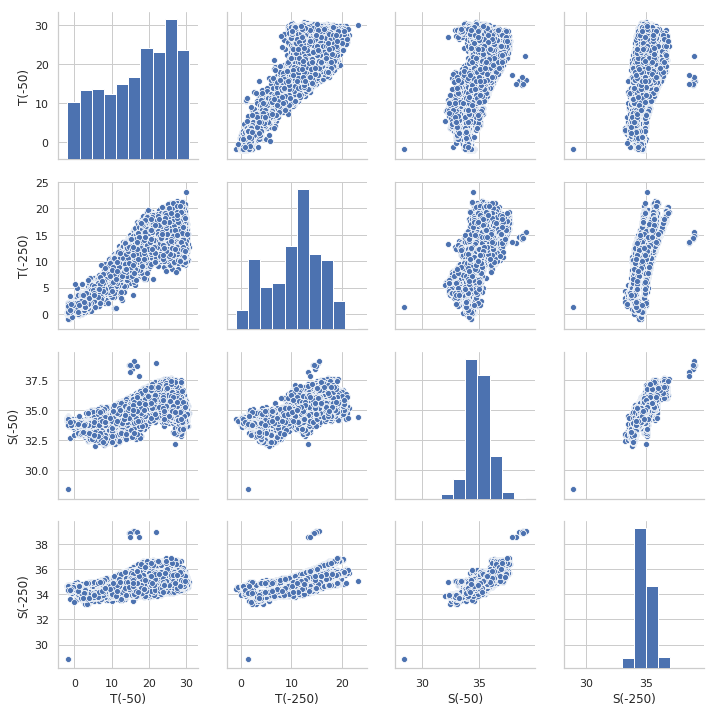

In [18]:
# Creare a simple 2D numpy array for scikit-learn
import pandas as pd
ii = np.random.choice(range(ds['N_PROF'].shape[0]), 10000, replace=False)
X = np.append(ds['TEMP'].sel(DEPTH=-50, method='nearest')[ii].values[np.newaxis].T,\
              ds['TEMP'].sel(DEPTH=-250, method='nearest')[ii].values[np.newaxis].T,axis=1)
X = np.append(X,ds['PSAL'].sel(DEPTH=-50, method='nearest')[ii].values[np.newaxis].T, axis=1)
X = np.append(X,ds['PSAL'].sel(DEPTH=-250, method='nearest')[ii].values[np.newaxis].T, axis=1)
print X.shape

df = pd.DataFrame(X, columns=["T(-50)", "T(-250)", "S(-50)", "S(-250)"])
# df = pd.DataFrame(X)
sns.pairplot(df)
# g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
# g.map_offdiag(sns.kdeplot, n_levels=6)